In [1]:
#############################################################################
'''Importing Libraries'''
from Lethe_pyvista_tools import *
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
#############################################################################

In [2]:
#Ergun equation to predict pressure drop at fixed beds
def Ergun(inlet_velocity, mu, rhol, dp):
    eps_mf = 0.415
    delta_p = 0.23875*(150*inlet_velocity*mu*(1 - eps_mf)**2/(dp**2*eps_mf**3) + 1.75*inlet_velocity**2*rhol*(1 - eps_mf)/(dp*eps_mf**3))
    return delta_p

deltap_Ergun = Ergun(0.02, 0.0000008379*996.7775, 996.7775, 0.00308724)

In [3]:
#Read fluid files
fluid = Lethe_pyvista_tools('D:/results/lethe/alumina/q1-q1', 'first_case.prm')
fluid.read_lethe_to_pyvista('result_.pvd')


Reading VTU files: 0it [00:00, ?it/s]

Successfully constructed. To see the .prm dictionary, print($NAME.prm_dict)


Reading VTU files: 22it [00:02, 10.13it/s]

Written .df_timestep from timestep = 0 to timestep = 22


In [4]:
#Read particles files
particle = Lethe_pyvista_tools('D:/results/lethe/alumina/q1-q1', 'first_case.prm')
particle.read_lethe_to_pyvista('result_particles.pvd')

Successfully constructed. To see the .prm dictionary, print($NAME.prm_dict)


Written .df_timestep from timestep = 0 to timestep = 23


In [5]:
#Pyvista object
print(fluid.df_0)

UnstructuredGrid (0x210fd467580)
  N Cells:	10560
  N Points:	84480
  X Bounds:	-5.500e-01, 5.500e-01
  Y Bounds:	-5.000e-02, 5.000e-02
  Z Bounds:	-5.000e-02, 5.000e-02
  N Arrays:	6



In [6]:
#print the name of the arrays in pyvista object
print(f'Fluid arrays: {fluid.df_0.array_names}')
print(f'Particles arrays: {particle.df_0.array_names}')

Fluid arrays: ['velocity', 'vorticity', 'pressure', 'q_criterion', 'void_fraction', 'subdomain']
Particles arrays: ['Velocity', 'Omega', 'FemForce', 'ID', 'Type', 'Diameter']


In [7]:
#print coordinates to mesh points
print(fluid.df_0.points)

Reading VTU files: 23it [00:03,  6.48it/s]

[[-0.55        0.03535534 -0.03535534]
 [-0.55        0.01913417 -0.04619398]
 [-0.5416667   0.03535534 -0.03535534]
 ...
 [ 0.5416667  -0.01464466  0.01464466]
 [ 0.55       -0.01982233  0.01982233]
 [ 0.55       -0.01464466  0.01464466]]


In [8]:
#print the type of the fluid.df_
print(type(fluid.df_0['pressure']))

<class 'numpy.ndarray'>


In [9]:
#using prm_dict to show the attributes

fluid.density = fluid.prm_dict['density']
print(f'The fluid density is {fluid.density} kg/m³')

particle.diameter = particle.prm_dict['diameter']
print(f'The diameter of the particles is {particle.diameter*1000} mm')

The fluid density is 996.7775 kg/m³
The diameter of the particles is 3.0872400000000004 mm


Reading VTU files: 22it [00:07,  3.11it/s]


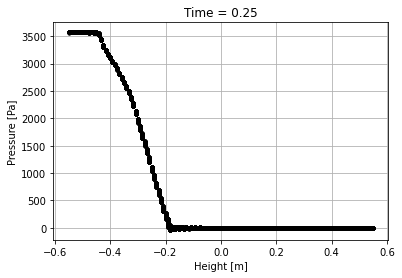

In [10]:
#Example of plot data
plt.plot(fluid.df_1.points[:, 0], fluid.df_1['pressure']*fluid.density, '.k')
plt.title(f'Time = {fluid.time_list[1]}')
plt.ylabel('Pressure [Pa]')
plt.xlabel('Height [m]')
plt.grid()
plt.show()

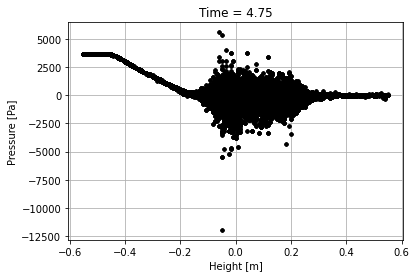

In [11]:
#Use exec to make changes easier:
timestep = 19
exec(f'plt.plot(fluid.df_{timestep}.points[:, 0], fluid.df_{timestep}[\'pressure\']*fluid.density, \'.k\')') #make sure to put the \ before any '
plt.title(f'Time = {fluid.time_list[timestep]}')
plt.ylabel('Pressure [Pa]')
plt.xlabel('Height [m]')
plt.grid()
plt.show()

In [12]:
#Dealing with verctorial variables:
print(fluid.df_0)
fluid.df_0['velocity_x'] = fluid.df_0['velocity'][:, 0]

print(fluid.df_0['velocity'][:, 0] == fluid.df_0['velocity_x'])
print(fluid.df_0['velocity_x'])

UnstructuredGrid (0x171fc8785e0)
  N Cells:	10560
  N Points:	84480
  X Bounds:	-5.500e-01, 5.500e-01
  Y Bounds:	-5.000e-02, 5.000e-02
  Z Bounds:	-5.000e-02, 5.000e-02
  N Arrays:	6

[ True  True  True ...  True  True  True]
[0.0951 0.0951 0.     ... 0.     0.     0.    ]


In [13]:
#Doing the same for all dfs
for i in range(len(fluid.list_vtu)):
    exec(f'fluid.df_{i}[\'velocity_x\'] = fluid.df_{i}[\'velocity\'][:, 0]')

for i in range(len(fluid.list_vtu)):
    exec(f'fluid.df_{i}[\'velocity_mag\'] = (fluid.df_{i}[\'velocity\'][:, 0]**2 + fluid.df_{i}[\'velocity\'][:, 1]**2 + fluid.df_{i}[\'velocity\'][:, 2]**2)**(1/2)')

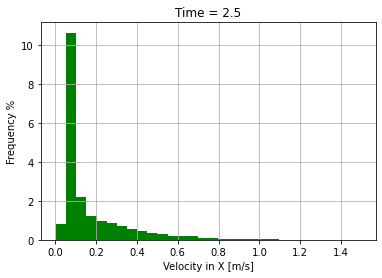

In [14]:
timestep = 10
exec(f'plt.hist(fluid.df_{timestep}[\'velocity_mag\'], bins = 30, color = \'green\', density = True)') #make sure to put the \ before any '
plt.title(f'Time = {fluid.time_list[timestep]}')
plt.ylabel('Frequency %')
plt.xlabel('Velocity in X [m/s]')
plt.grid()
plt.show()

In [15]:
def create_particles(df_name):
    df = df_name

    #create a sphere with diameter 1
    sphere = pv.Sphere(theta_resolution=10, phi_resolution=10)

    # create spheres scaled to the diameter of the array "Diameter"
    df_glyph = df.glyph(scale='Diameter', geom=sphere)

    # compute normalized velocity
    #df_glyph['Velocity_Norm'] = np.linalg.norm(df_glyph['Velocity'], axis=1)
    return df_glyph

In [16]:
#Choose the white background for the figure
pv.set_plot_theme("document") #background white
#Create a plotter
plotter = pv.Plotter(off_screen=None)
# create spheres scaled to the diameter of the array "Diameter"
df_glyph = create_particles(particle.df_10)
#Add data to the plotter
plotter.add_mesh(df_glyph, cmap = 'turbo', scalars = 'Velocity', smooth_shading=True, scalar_bar_args={'color': 'k', 'vertical': True})
#Define camera position
plotter.camera_position = 'xy'
plotter.camera.roll += 90

plotter.show() #to save the file at the case folder, put `screenshot=f'{object.path_case}/name_of_file.png'`

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [17]:
#Choose the white background for the figure
pv.set_plot_theme("document") #background white
#Create a plotter
plotter_2 = pv.Plotter(off_screen=None)
# create spheres scaled to the diameter of the array "Diameter"
df_glyph = create_particles(particle.df_10)
#Add data to the plotter
plotter_2.add_mesh(df_glyph, cmap = 'turbo', scalars = 'Velocity', smooth_shading=True, scalar_bar_args={'color': 'k', 'vertical': True})
#Define camera position
plotter_2.camera_position = 'xy'
plotter_2.camera.roll += 90

plotter_2.open_gif(f"{particle.path_case}/particles_gif_example.gif")


for i in range(len(particle.list_vtu)):
    exec(f'df = particle.df_{i}')
    df_glyph = create_particles(df)
    df_glyph.active_scalars_name = 'Velocity'
    plotter_2.mesh.overwrite(df_glyph)
    plotter_2.add_text(f"Time: {particle.time_list[i]}", name='Time_label')
    plotter_2.write_frame()